In [1]:
import pandas as pd
import warnings
import itertools
import random
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
warnings.filterwarnings(action="ignore")

## Model Selection and Tuning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression,Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline


# Machine Learning Model Evaluation Methods
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

In [3]:
df = pd.read_csv('train_revised.csv', parse_dates=['travel_date'])
df.head()

,ride_id,seat_number,payment_method,payment_receipt,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity
0,1442,15A,Mpesa,UZUEHCBUSO,2017-10-17,7:15,Migori,Nairobi,Bus,49
1,5437,14A,Mpesa,TIHLBUSGTE,2017-11-19,7:12,Migori,Nairobi,Bus,49
2,5710,8B,Mpesa,EQX8Q5G19O,2017-11-26,7:05,Keroka,Nairobi,Bus,49
3,5777,19A,Mpesa,SGP18CL0ME,2017-11-27,7:10,Homa Bay,Nairobi,Bus,49
4,5778,11A,Mpesa,BM97HFRGL9,2017-11-27,7:12,Migori,Nairobi,Bus,49


In [4]:
df['travel_date'] = pd.to_datetime(df['travel_date'])

# Extract date, month, and year into separate columns using apply and a lambda function
df['date'] = df['travel_date'].apply(lambda x: x.day)
df['month'] = df['travel_date'].apply(lambda x: x.month)
df['year'] = df['travel_date'].apply(lambda x: x.year)

df.head()


,ride_id,seat_number,payment_method,payment_receipt,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity,date,month,year
0,1442,15A,Mpesa,UZUEHCBUSO,2017-10-17,7:15,Migori,Nairobi,Bus,49,17,10,2017
1,5437,14A,Mpesa,TIHLBUSGTE,2017-11-19,7:12,Migori,Nairobi,Bus,49,19,11,2017
2,5710,8B,Mpesa,EQX8Q5G19O,2017-11-26,7:05,Keroka,Nairobi,Bus,49,26,11,2017
3,5777,19A,Mpesa,SGP18CL0ME,2017-11-27,7:10,Homa Bay,Nairobi,Bus,49,27,11,2017
4,5778,11A,Mpesa,BM97HFRGL9,2017-11-27,7:12,Migori,Nairobi,Bus,49,27,11,2017


In [5]:
train = df.groupby(['ride_id', 'travel_time','travel_date','date','month','travel_from','max_capacity','payment_method','car_type']).size().reset_index(name='Count') #sort=False if needed?
train["travel_time"] = train["travel_time"].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
train['day'] = train['travel_date'].dt.dayofweek

In [6]:
train.head()

,ride_id,travel_time,travel_date,date,month,travel_from,max_capacity,payment_method,car_type,Count,day
0,1442,435,2017-10-17,17,10,Migori,49,Mpesa,Bus,1,1
1,5437,432,2017-11-19,19,11,Migori,49,Mpesa,Bus,1,6
2,5710,425,2017-11-26,26,11,Keroka,49,Mpesa,Bus,1,6
3,5777,430,2017-11-27,27,11,Homa Bay,49,Mpesa,Bus,5,0
4,5778,432,2017-11-27,27,11,Migori,49,Mpesa,Bus,31,0


In [7]:
train.drop_duplicates(subset='ride_id', keep='first', inplace=True)

In [8]:
# I did the same for the test data
test = pd.read_csv('test_questions.csv', parse_dates=['travel_date'], dayfirst=True).drop(['car_type', 'travel_to'], axis=1)
test["travel_time"] = test["travel_time"].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
#test['day'] = test['travel_date'].dt.dayofweek

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6249 entries, 0 to 6290
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ride_id         6249 non-null   int64         
 1   travel_time     6249 non-null   int64         
 2   travel_date     6249 non-null   datetime64[ns]
 3   date            6249 non-null   int64         
 4   month           6249 non-null   int64         
 5   travel_from     6249 non-null   object        
 6   max_capacity    6249 non-null   int64         
 7   payment_method  6249 non-null   object        
 8   car_type        6249 non-null   object        
 9   Count           6249 non-null   int64         
 10  day             6249 non-null   int32         
dtypes: datetime64[ns](1), int32(1), int64(6), object(3)
memory usage: 561.4+ KB


In [10]:
train.describe()

,ride_id,travel_time,travel_date,date,month,max_capacity,Count,day
count,6249.000000,6249.000000,6249,6249.000000,6249.000000,6249.000000,6249.000000,6249.000000
mean,9963.644583,494.389662,2018-03-03 08:37:19.846375424,13.832133,5.761402,30.392223,8.200832,2.913906
min,1442.000000,300.000000,2017-01-12 00:00:00,1.000000,1.000000,11.000000,1.000000,0.000000
25%,7989.000000,424.000000,2017-12-28 00:00:00,3.000000,2.000000,11.000000,2.000000,1.000000
50%,10024.000000,430.000000,2018-02-21 00:00:00,14.000000,4.000000,49.000000,6.000000,3.000000
75%,11917.000000,520.000000,2018-04-17 00:00:00,21.000000,10.000000,49.000000,11.000000,5.000000
max,20117.000000,1390.000000,2018-12-04 00:00:00,31.000000,12.000000,49.000000,50.000000,6.000000
std,2296.304872,177.108812,NaN,9.301234,4.076164,18.997471,8.617874,1.958013


#Insights
###This dataset has a total of 6249 observation in total. No missingness was observed in this data.
###We have both categorical and numerical data.

In [22]:
num_var=train.select_dtypes(include=[np.number])


In [23]:
cat_var=train.select_dtypes(include=[object])

In [24]:
train.head(2)

,ride_id,travel_time,travel_date,date,month,travel_from,max_capacity,payment_method,car_type,Count,day
0,1442,435,2017-10-17,17,10,Migori,49,Mpesa,Bus,1,1
1,5437,432,2017-11-19,19,11,Migori,49,Mpesa,Bus,1,6


In [25]:
num_var.head()

,ride_id,travel_time,date,month,max_capacity,Count,day
0,1442,435,17,10,49,1,1
1,5437,432,19,11,49,1,6
2,5710,425,26,11,49,1,6
3,5777,430,27,11,49,5,0
4,5778,432,27,11,49,31,0


Text(0.5, 1.0, 'Missing Values Heatmap')

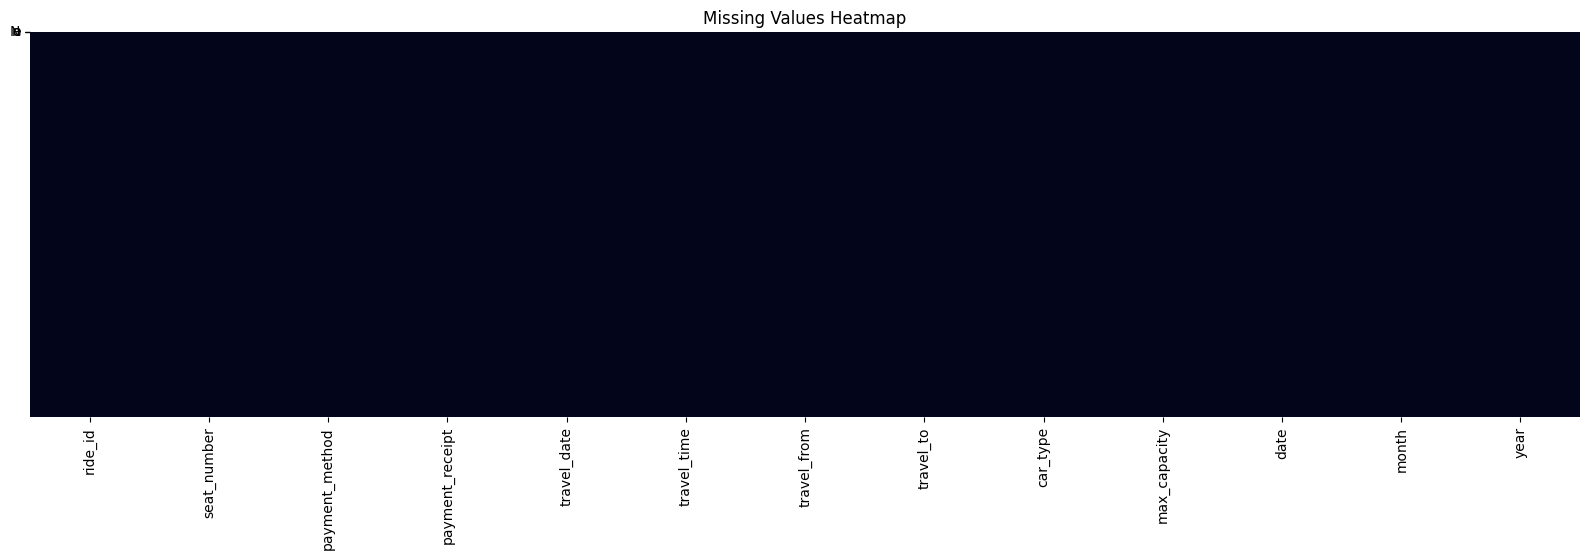

In [18]:
plt.figure(figsize=(20,5))

sns.heatmap(df.isnull(), yticklabels="None", cbar=False)
plt.title("Missing Values Heatmap")

###This confirms that no missingness was observed.

# Outlier Exploration

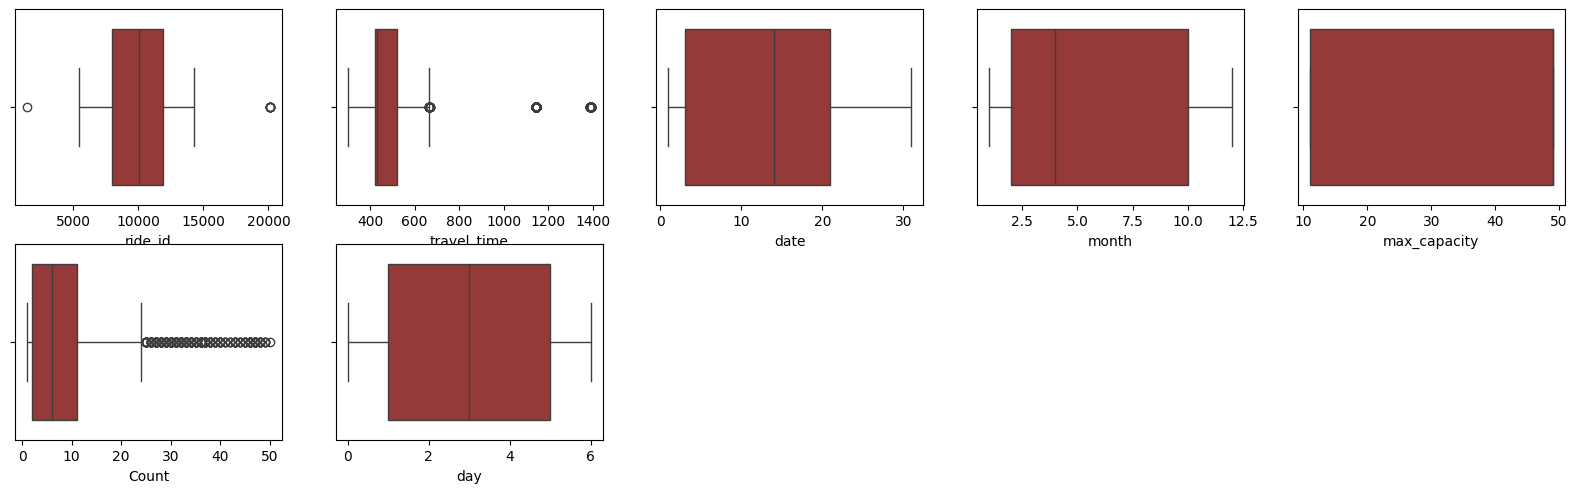

In [19]:
fig = plt.figure(figsize=(20,30))
for i,j in zip(num_var,range(len(num_var.columns))):
    ax = fig.add_subplot(10,5, j+1)
    sns.boxplot(data=train,x=train[i],orient='v',color="brown")

# Label encoding

In [26]:
label_encoder = LabelEncoder()

# Here I Encoded the 'travel_from' column
train['travel_from_encoded'] = label_encoder.fit_transform(train['travel_from'])

# Display the mapping of original categories to encoded labels
print("Mapping of original categories to encoded labels:")
for index, label in enumerate(label_encoder.classes_):
    print(f"{label}: {index}")


Mapping of original categories to encoded labels:
Awendo: 0
Homa Bay: 1
Kehancha: 2
Kendu Bay: 3
Keroka: 4
Keumbu: 5
Kijauri: 6
Kisii: 7
Mbita: 8
Migori: 9
Ndhiwa: 10
Nyachenge: 11
Oyugis: 12
Rodi: 13
Rongo: 14
Sirare: 15
Sori: 16


In [27]:
train['payment_method_encoded'] = label_encoder.fit_transform(train['payment_method'])

# Display the mapping of original categories to encoded labels
print("Mapping of original categories to encoded labels:")
for index, label in enumerate(label_encoder.classes_):
    print(f"{label}: {index}")

Mapping of original categories to encoded labels:
Cash: 0
Mpesa: 1


In [29]:
train['car_type_encoded'] = label_encoder.fit_transform(train['car_type'])

# Display the mapping of original categories to encoded labels
print("Mapping of original categories to encoded labels:")
for index, label in enumerate(label_encoder.classes_):
    print(f"{label}: {index}")

Mapping of original categories to encoded labels:
Bus: 0
shuttle: 1


In [30]:
train.head(2)

,ride_id,travel_time,travel_date,date,month,travel_from,max_capacity,payment_method,car_type,Count,day,travel_from_encoded,payment_method_encoded,car_type_encoded
0,1442,435,2017-10-17,17,10,Migori,49,Mpesa,Bus,1,1,9,1,0
1,5437,432,2017-11-19,19,11,Migori,49,Mpesa,Bus,1,6,9,1,0


#Minmax scaling

In [17]:
#MINMAX
columns_to_scale = [col for col in train.columns if train[col].dtype in ['int64', 'float64']]

scaler = MinMaxScaler()

df_scale = scaler.fit_transform(train[columns_to_scale])

df_normalized = pd.DataFrame(df_scale, columns=columns_to_scale)

df_normalized = pd.concat([df_normalized, train.drop(columns=columns_to_scale)], axis=1)

df_normalized.head()


,ride_id,travel_time,max_capacity,Count,travel_from_encoded,car_type_encoded,travel_date,travel_from,car_type,day
0,0.000000,0.123853,1.0,0.000000,0.5625,0.0,2017-10-17,Migori,Bus,1
1,0.213922,0.121101,1.0,0.000000,0.5625,0.0,2017-11-19,Migori,Bus,6
2,0.228541,0.114679,1.0,0.000000,0.2500,0.0,2017-11-26,Keroka,Bus,6
3,0.232129,0.119266,1.0,0.081633,0.0625,0.0,2017-11-27,Homa Bay,Bus,0
4,0.232182,0.121101,1.0,0.612245,0.5625,0.0,2017-11-27,Migori,Bus,0


separate the dates
code block into sections
add payment methods
inckude the scaling in the pipeline

In [36]:
X = train.drop(columns=['Count','travel_from','travel_date','car_type','payment_method'],axis=1)
y = train['Count']

print(X.shape,y.shape)

(6249, 9) (6249,)


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=20)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4374, 9) (1875, 9) (4374,) (1875,)


In [38]:
X.head()

,ride_id,travel_time,date,month,max_capacity,day,travel_from_encoded,payment_method_encoded,car_type_encoded
0,1442,435,17,10,49,1,9,1,0
1,5437,432,19,11,49,6,9,1,0
2,5710,425,26,11,49,6,4,1,0
3,5777,430,27,11,49,0,1,1,0
4,5778,432,27,11,49,0,9,1,0


In [39]:

pipe = make_pipeline(MinMaxScaler(),PolynomialFeatures(degree=1), LinearRegression())
scores = cross_val_score(pipe, X, y, cv=5, scoring='r2')

print(scores, scores.mean())

[-0.04646638  0.02734276  0.08520777  0.11172728  0.06895547] 0.049353380325409237


In [40]:
from sklearn.linear_model import LinearRegression,Ridge, Lasso

pipe = make_pipeline(MinMaxScaler(),PolynomialFeatures(degree=1), Ridge(alpha=100))
scores = cross_val_score(pipe, X, y, cv=5, scoring='r2')

print(scores, scores.mean())

[-0.00189518  0.03256495  0.07813666  0.08232303  0.07553234] 0.05333236100109277


In [41]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
scores = cross_val_score(model, X, y, cv=5, scoring='r2')

print(scores, scores.mean())

[0.11957838 0.31832104 0.3673876  0.56744864 0.50238753] 0.3750246367033929
